<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/GaussianMRFExample_lbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Loopy Belief Propagation

We start from the same "image MRF, with unary and pairwise Gaussian factors. We then implement loopy belief propagation.

In [9]:
%pip -q install gtbook  # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [10]:
import math
import numpy as np
from collections import defaultdict
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook.display import show
from gtsam import noiseModel

def square(vv):
    result = gtsam.VectorValues()
    for k in key_list:
        result.insert(k, vv.at(k)**2)
    return result

## A Small "Image" MRF


All the code to create the small image "MRF" in one cell:

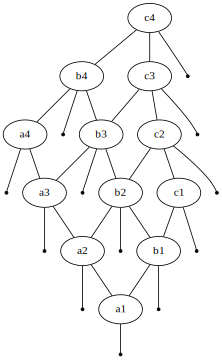

In [11]:
M, N = 3, 4  # try playing with this
row_symbols = [chr(ord('a')+row) for row in range(M)]
keys = {(row, col): gtsam.symbol(row_symbols[row], col+1)
       for row in range(M) for col in range(N)}

sigma = 0.5
rng = np.random.default_rng(42)
data = rng.normal(loc=0, scale=sigma, size=(M, N, 1))
data_model = noiseModel.Isotropic.Sigmas([sigma])

smoothness_sigma = 0.5
smoothness_model = noiseModel.Isotropic.Sigmas([smoothness_sigma])

I = np.eye(1, 1, dtype=float)
zero = np.zeros((1,1))
graph = gtsam.GaussianFactorGraph()
for row in range(M):
    for col in range(N):
        # add data terms:
        j = keys[(row,col)]
        graph.add(j, I, np.array(data[row,col]), data_model)
        # add smoothness terms:
        if col>0:
            j1 = keys[(row,col-1)]
            graph.add(j, I, j1, -I, zero, smoothness_model)
        if row>0:
            j2 = keys[(row-1,col)]
            graph.add(j, I, j2, -I, zero, smoothness_model)

position_hints = {c:float(-i) for i,c in enumerate(row_symbols)}
show(graph, binary_edges=True) # you can add hints=position_hints for a different view

And the data image is shown here:

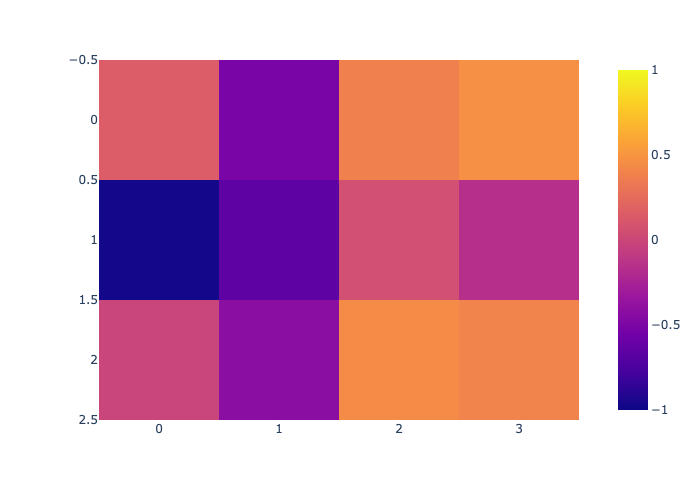

In [12]:
px.imshow(data[:,:,0], zmin=-1, zmax=1)

## Loopy Belief Propagation

We initialize a set of individual *Gaussian* factors $q(x_j)$ or *beliefs*, one for each variable. LBP is a fixed point algorithm to minimize the KL $D_\text{KL}(p||q)$ divergence between the true posterior $p(X|Z)$ and the variational approximation

$$
q(X) = \prod_j q(x_j)
$$

We repeatedly:

- pick a variable $x_j$ at random;
- consider the Markov blanket of $x_j$, the factor graph fragment $\phi(x_j, X_j)$ where $X_j$ is the separator;
- augment the factor graph fragment with (downdated) beliefs on all $x_k\in X_j$, *except* $q(x_j)$;
- eliminate the separator $X_j$ by factorizing this graph as $p(X_j|x_j)q'(x_j)$;
- assign $q(x_j) \leftarrow q'(x_j)$ to be the new belief on $x_j$.

We first cache all Markov blankets:

In [13]:
local_factor_indices =  defaultdict(list)
markov_blankets = defaultdict(gtsam.GaussianFactorGraph)
for i in range(graph.size()):
    factor = graph.at(i)
    for j in factor.keys():
        local_factor_indices[j].append(i)
        markov_blankets[j].add(factor)

Here are the Markov blanket for $x_{a1}$ and $x_{b2}$:

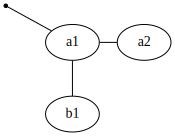

In [14]:
show(markov_blankets[keys[0,0]], binary_edges=True, hints=position_hints)

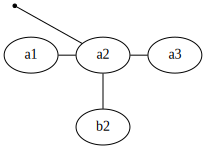

In [15]:
show(markov_blankets[keys[0,1]], binary_edges=True, hints=position_hints)

We initialize the beliefs in *information form* by using a `HessianFactor`, whose constructor reads as follows:

```c++
/** Construct a unary factor.  G is the quadratic term (Hessian matrix), g
* the linear term (a vector), and f the constant term.  The quadratic
* error is:
* 0.5*(f - 2*x'*g + x'*G*x)
*/
HessianFactor(Key j, const Matrix& G, const Vector& g, double f);
```

The entire LPB code is then:

In [16]:
def lbp(x0: gtsam.VectorValues, hook=None, max_iterations=100, seed=42):
    """Perform loopy belief propagation with initial estimate x."""
    rng = np.random.default_rng(seed)
    key_list = list(keys.values())
    x = gtsam.VectorValues(x0)
    error = graph.error(x)
    # Initialize belief and messages
    q = {key: gtsam.HessianFactor(key, G=np.eye(1), g=5*np.zeros(
        (1, 1)), f=0) for key in key_list}
    messages = defaultdict(dict)
    hook(0, None, x, q, error)

    def downdated_belief(i: int, k: int):
        """Get belief on k, downdated with message from i->k"""
        # Get belief for variable k
        G = np.array(q[k].information())
        g = np.array(q[k].linearTerm())
        f = 0.0 + q[k].constantTerm()
        # Down-date if a message from factor -> k is on file
        if k in messages[i]:
            ik = messages[i][k]
            G -= ik.information()
            g -= ik.linearTerm()
            f -= ik.constantTerm()
        downdated = gtsam.HessianFactor(k, G, g, f)
        return downdated

    def get_message(i: int, j: int):
        """Get message from factor to j"""
        factor = graph.at(i)
        if factor.size() == 1:
            return factor
        edge_graph = gtsam.GaussianFactorGraph()
        edge_graph.push_back(factor)
        ordering = gtsam.Ordering()
        for k in factor.keys():
            if k != j:
                k_to_factor = downdated_belief(i, k)
                edge_graph.add(k_to_factor)
                ordering.push_back(k)
        _, remaining = edge_graph.eliminatePartialSequential(ordering)
        return remaining.at(0)

    def update(j: int, x: gtsam.VectorValues):
        """Augment Markov blanket and eliminate to x_j"""
        # Calculate "messages" from all factors in Markov blanket:
        augmented_graph = gtsam.GaussianFactorGraph()
        for i in local_factor_indices[j]:
            message = get_message(i, j)
            messages[i][j] = message
            augmented_graph.push_back(message)

        # Eliminate with x_j eliminated last:
        ordering = gtsam.Ordering.ColamdConstrainedLastGaussianFactorGraph(
            augmented_graph, [j])
        gbn = augmented_graph.eliminateSequential(ordering)
        q_prime = gbn.at(gbn.size()-1)
        delta = q_prime.solve(gtsam.VectorValues())
        new_x = gtsam.VectorValues(x)
        new_x.update(delta)  # imperative !
        q[j] = gtsam.HessianFactor(q_prime)
        return new_x

    for it in range(1, max_iterations+1):
        if error < 1e-1:
            break
        # choose a variable whose belief to update
        j = key_list[rng.choice(M*N)]
        new_x = update(j, x)
        if new_x is not None:
            error = graph.error(new_x)
            hook(it, j, x, q, error)
            x = new_x
    return x, q

# x, q = lbp(initial, print_hook, max_iterations=150)

We initialize to the data:

In [17]:
rng = np.random.default_rng(42)
initial = gtsam.VectorValues()
for row in range(M):
    for col in range(N):
        j = keys[(row,col)]
        initial.insert(j, data[row,col])

In [18]:
def print_hook(it, j, x, q, error):
    if it % 10 == 0:
        if it==0:
            print(f"{it=}, initial error is {error}")
        else:
            print(f"{it=}, updated {gtsam.DefaultKeyFormatter(j)}, error now {error}")

x, q = lbp(initial, print_hook, max_iterations=150)

it=0, initial error is 12.126645986142575
it=10, updated a2, error now 8.548142818772295
it=20, updated b2, error now 8.353342362950402
it=30, updated b2, error now 4.6349545784124935
it=40, updated b4, error now 3.3201819174813973
it=50, updated c2, error now 3.1730670682297273
it=60, updated c1, error now 3.146132851392824
it=70, updated b2, error now 3.1451440300419513
it=80, updated c1, error now 3.144632390491705
it=90, updated c2, error now 3.1443168387318106
it=100, updated a2, error now 3.144109271241281
it=110, updated c1, error now 3.144059279989692
it=120, updated a2, error now 3.1440483981301504
it=130, updated b4, error now 3.1440494393988265
it=140, updated b2, error now 3.144047062937116
it=150, updated a1, error now 3.143998782825293


We compare the mean with the exact mean and see that LBP converges to the correct mean value:

In [19]:
stddev = np.empty((M*N,))
for i, (j,qj) in enumerate(q.items()):
    information = qj.information().item()
    stddev[i] = 1.0/math.sqrt(information)
    print(f"{gtsam.DefaultKeyFormatter(j)} {x.at(j).item():.2f} +/- {stddev[i]:.2f}")

a1 -0.16 +/- 0.32
a2 -0.22 +/- 0.28
a3 0.09 +/- 0.28
a4 0.21 +/- 0.32
b1 -0.41 +/- 0.29
b2 -0.30 +/- 0.25
b3 0.00 +/- 0.25
b4 0.06 +/- 0.29
c1 -0.21 +/- 0.32
c2 -0.21 +/- 0.28
c3 0.11 +/- 0.28
c4 0.18 +/- 0.32


The exact mean is calculated below, as well as the exact standard deviations.

In [20]:
key_list = list(keys.values())
bayes_tree = graph.eliminateMultifrontal()
exact_mean = bayes_tree.optimize()
exact_stddev = np.empty((M*N,))
for i, j in enumerate(key_list):
    variance = bayes_tree.marginalCovariance(j)
    exact_stddev[i] = math.sqrt(variance)    
    print(f"{gtsam.DefaultKeyFormatter(j)} {exact_mean.at(j).item():.2f} +/- {exact_stddev[i]:.2f}")
print(f"direct solver error: {graph.error(exact_mean)}")

a1 -0.16 +/- 0.33
a2 -0.22 +/- 0.29
a3 0.09 +/- 0.29
a4 0.21 +/- 0.33
b1 -0.41 +/- 0.29
b2 -0.30 +/- 0.26
b3 0.00 +/- 0.26
b4 0.06 +/- 0.29
c1 -0.21 +/- 0.33
c2 -0.21 +/- 0.29
c3 0.11 +/- 0.29
c4 0.18 +/- 0.33
direct solver error: 3.1439968801524447


As you can see, the LBP approximation is a bit over-confident. This is a well known property of LBP. we show the effect side by side again below, with LBP $\mu/\sigma$ in the top row, and exact $\mu/\sigma$ in the bottom row.

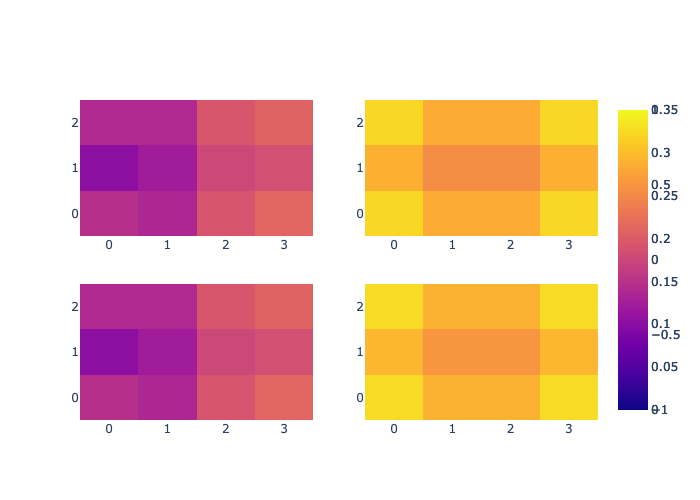

In [21]:
fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Heatmap(z=x.vector().reshape((M, N)), zmin=-1, zmax=1), row=1, col=1)
fig.add_trace(go.Heatmap(z=exact_mean.vector().reshape((M, N)), zmin=-1, zmax=1), row=2, col=1)
fig.add_trace(go.Heatmap(z=stddev.reshape((M, N)), zmin=0, zmax=0.35), row=1, col=2)
fig.add_trace(go.Heatmap(z=exact_stddev.reshape((M, N)), zmin=0, zmax=0.35), row=2, col=2)
fig.show()


However, convergence is slow.

## Gibbs Sampling

Gibbs sampling is a variant of Markov Chain Monte Carlo sampling that always accepts any proposal.


We repeatedly:

- pick a variable $x_j$ at random;
- consider the Markov blanket of $x_j$, the factor graph fragment $\phi(x_j, X_j)$ where $X_j$ is the separator;
- eliminate the variable $x_j$ by factorizing $\phi(x_j, X_j) = p(x_j|X_j)\phi(X_j)$;
- sample $x_j$ $\phi(x_j, X_j)$.

We first compute all conditionals $p(x_j|X_j)$, which we can do *in advance*, as well as the inverse square root covariances $R_j^{-1}$, which we need for sampling. An advantage of working in square-root information form (like the entirety of GTSAM) is that less computation is needed *and* it is numerically more stable:

In [22]:
conditionals = {}
invR = {}
for j in key_list:
    local_graph = markov_blankets[j]
    # Eliminate just x_j:
    ordering = gtsam.Ordering()
    ordering.push_back(j)
    gbn, _ = local_graph.eliminatePartialSequential(ordering)
    conditionals[j] = gbn.at(0)
    invR[j] = np.linalg.inv(conditionals[j].R())

The conditional is parameterized by $R$, $S$ and $d$ as follows:

$$
p(x_j|X_j) \propto \exp \{-0.5 \|R x_j + S X_j - d\|^2\}
$$

A Gibbs proposal for variable $j$ then just assembles the separator $X_j$ and samples from the conditional like so:

$$
s_j = R_j^{-1} [d - S X_j + u] = \mu(X_j) + R_j^{-1} u
$$

where $\mu(X_j) = R_j^{-1} [d - S X_j]$ is the conditional mean and $u$ is drawn from a standard zero-mean Gaussian with identity covariance. 

In [23]:
rng = np.random.default_rng(42)

def proposal(x, j):
    """Propose via Gibbs sampling"""
    # Get Conditional for x_j, computed above
    conditional = conditionals[j]
    # sample x_j and propose a new sample
    rhs = conditional.d().reshape(1, 1)
    key, *parents = conditional.keys()
    rhs = rhs - conditional.S() @ np.vstack([x.at(p) for p in parents])
    # sample from conditional Gaussian
    sample = gtsam.VectorValues()
    sample.insert(j, invR[j] @ (rhs + rng.normal()))
    new_x = gtsam.VectorValues(x)
    new_x.update(sample)
    return new_x

We also create a hook to keep sufficient statistics:

In [24]:
global count, sum, sum_squares
count = 0
sum = gtsam.VectorValues.Zero(initial)
sum_squares = gtsam.VectorValues.Zero(initial)

def save_stats(it, y):
    global count, sum, sum_squares
    count += 1
    sum = sum.add(y)
    sum_squares = sum_squares.add(square(y))

The Gibbs sampler is then *exceedingly simple*:

In [25]:
# run Gibbs sampler
nr_iterations = M*N*200
y = gtsam.VectorValues(initial)
for it in range(nr_iterations):
    j = key_list[rng.choice(M*N)] # choose a variable to perturb
    y = proposal(y, j)
    if it >= nr_iterations//2: save_stats(it, y)

Because we kept the sufficient statistics `count`, `sum`, and `sum_squares` we can compute the marginals:

In [26]:
gibbs_mean = sum.scale(1.0/count)
avg_deviation = sum_squares.scale(1.0/count)
variance = avg_deviation.subtract(square(gibbs_mean))

print(f"Marginals computed from {count} correlated samples:")
gibbs_stddev = np.empty((M*N,))
for i, j in enumerate(key_list):
    gibbs_stddev[i] = math.sqrt(variance.at(j))
    print(f"{gtsam.DefaultKeyFormatter(j)} {gibbs_mean.at(j).item():.2f} +/- {gibbs_stddev[i]:.2f}")
print(f"The error at the mean is {graph.error(gibbs_mean)}.")

Marginals computed from 1200 correlated samples:
a1 -0.17 +/- 0.35
a2 -0.26 +/- 0.27
a3 0.13 +/- 0.29
a4 0.17 +/- 0.34
b1 -0.37 +/- 0.37
b2 -0.29 +/- 0.26
b3 0.04 +/- 0.26
b4 -0.00 +/- 0.26
c1 -0.16 +/- 0.41
c2 -0.22 +/- 0.33
c3 0.11 +/- 0.27
c4 0.17 +/- 0.31
The error at the mean is 3.243985130848141.


Comparing these with the direct solver solution above you can see that the mean converges, *as well as the standard deviations*. We also show this graphically below:

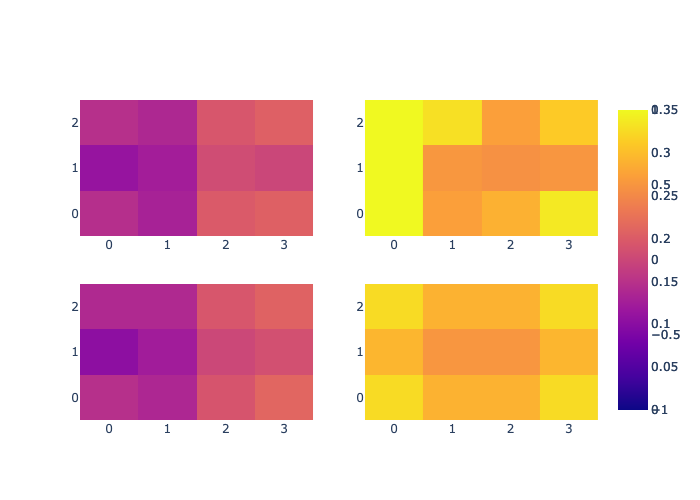

In [27]:
fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Heatmap(z=gibbs_mean.vector().reshape((M, N)), zmin=-1, zmax=1), row=1, col=1)
fig.add_trace(go.Heatmap(z=exact_mean.vector().reshape((M, N)), zmin=-1, zmax=1), row=2, col=1)
fig.add_trace(go.Heatmap(z=gibbs_stddev.reshape((M, N)), zmin=0, zmax=0.35), row=1, col=2)
fig.add_trace(go.Heatmap(z=exact_stddev.reshape((M, N)), zmin=0, zmax=0.35), row=2, col=2)
fig.show()

## Elimination vs. Message Passing

Above we implemented LBP with elimination, where the root of the eliminated graph becomes the new belief $q_j(x_j)$. The duality with Gibbs sampling is clear, and it is very natural if you are familiar with the elimination on factor graphs.

However, LBP is traditionally explained/implemented with a more complex "message passing" algorithm, with two different types of messages (variable to factor, and factor to variable). Are they in fact the same? Using the small example for the top-left pixel below we will show that they are indeed.

Below we show the Markov blanket for $a1$, which has three factors. Let us name the unary factor $f_{a1}$, and the binary factors $f_{a2}$ and $f_{b1}$:

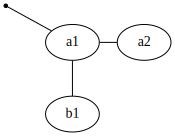

In [28]:
show(markov_blankets[keys[0,0]], binary_edges=True, hints=position_hints)

On [this very cool tutorial from Imperial college](https://gaussianbp.github.io/) the more traditional view is explained beautifully. Three messages would be sent to $a1$ from the three factors:

$$
\begin{align*}
m_{f_{a1}\rightarrow a1}(a1) &= \phi(a1) \\ 
m_{f_{a2}\rightarrow a1}(a1) &= \int_{a2} \phi(a1, a2) m_{a2\rightarrow f_{a2}} (a2) \\
m_{f_{b1}\rightarrow a1}(a1) &= \int_{b1} \phi(a1, b1) m_{b1\rightarrow f_{b1}} (b1)
\end{align*}
$$

which are then combined in the belief update

$$
q(a1) \leftarrow m_{f_{a2}\rightarrow a1} (a1)~
m_{f_{b1}\rightarrow a1} (a1)~
m_{f_{a1}\rightarrow a1} (a1)
$$

The variable to factor messages $m_{x\rightarrow f} (x)$ are calculated as the beliefs, down-dated by the last message $m_{f\rightarrow x} (x)$ from $f$ to $x$:

$$
\begin{align*}
m_{a2\rightarrow f_{a2}} (a2) &= \frac{q(a2)}{m_{f_{a2}\rightarrow a2} (a2)} \\
m_{b1\rightarrow f_{b1}} (b1) &= \frac{q(b1)}{m_{f_{b1}\rightarrow b1} (b1)}.
\end{align*}
$$

This is slightly different from the traditional exposition, but equivalent. Hence the final belief update is

$$
q(a1) \leftarrow 
\phi(a1)
\{\int_{a2} \phi(a1, a2) \frac{q(a2)}{m_{f_{a2}\rightarrow a2} (a2)}\}
\{\int_{b1} \phi(a1, b1) \frac{q(b1)}{m_{f_{b1}\rightarrow b1} (b1)}\}
$$


LBP implemented by elimination yields obtains a new belief for $a1$ by factorizing the Markov blanket, augmented with *downdated* beliefs $\frac{q(a2)}{m_{f_{a2}\rightarrow a2} (a2)}$ and $\frac{q(b1)}{m_{f_{b1}\rightarrow b1} (b1)}$:

$$
\phi(a1) \{\phi(a1, a2)\frac{q(a2)}{m_{f_{a2}\rightarrow a2} (a2)}\} \{\phi(a1,b1)\frac{q(b1)}{m_{f_{b1}\rightarrow b1} (b1)}\} \propto q(a1) P(a2 | a1) P(b1 | a1),
$$

where $q(a1)$ is obtained by marginalizing out $a2$ and $b1$:

$$
\begin{align*}
q(a1) &= \int_{a2, b1} \phi(a1) \{\phi(a1, a2)\frac{q(a2)}{m_{f_{a2}\rightarrow a2} (a2)}\} \{\phi(a1,b1)\frac{q(b1)}{m_{f_{b1}\rightarrow b1} (b1)}\} \\
&= \phi(a1) \{\int_{a2} \phi(a1, a2)\frac{q(a2)}{m_{f_{a2}\rightarrow a2} (a2)}\} \{\int_{b1} \phi(a1,b1)\frac{q(b1)}{m_{f_{b1}\rightarrow b1} (b1)}\}.
\end{align*}
$$

This is exactly the same.